<a href="https://colab.research.google.com/github/maxmarkov/Kaggle-higgs/blob/master/zindi_insurance_fastai_baseline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zimnat Insurance Recommendation Challenge

The main objective of this notebook is to get familiar with [fastai](https://www.fast.ai/) (version 2) library working on [tabular](https://docs.fast.ai/tabular.core) data.

[Competition link](https://zindi.africa/competitions/zimnat-insurance-recommendation-challenge)

Some baselines with CatBoost: [github](https://github.com/Tixonmavrin/Zindi-Zimnat-Insurance-Recommendation-Challenge/blob/master/Baseline1.ipynb)

## 1. Import modules and get data from google drive.

Import the main external libraries.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

from IPython.display import clear_output

Install [PyDrive](https://github.com/gsuitedevs/PyDrive) and authenticate the user. [Documentation](https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html).

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Look for the file to get an ID.

In [3]:
files = drive.ListFile({'q': 'trashed=false'}).GetList()
file_list = ['Train.csv', 'Test.csv', 'SampleSubmission.csv', 'VariableDefinitions.txt']

for file in files:
   if file['title'] in file_list:
      print(file['title'], file['id'])

Train.csv 1S3DHJCd9wVI7s5ku6JusgIHHml5k5CvS
Test.csv 1-E1yMd_lv0p5pPfzT198vCQ_utI67xKK
VariableDefinitions.txt 1uDY-N9rlfx9KOYMclhIaW0nL7MlFe2kh
SampleSubmission.csv 1vFhazHBqD7TKMO1ZwP1ZXZEW2Zmgwq-Y


Download files from google drive

In [4]:
FOLDER = 'DATA_ZINDI'
if os.path.isdir(FOLDER) == False:
   os.mkdir(FOLDER)

file_train = drive.CreateFile({'id': '1S3DHJCd9wVI7s5ku6JusgIHHml5k5CvS'})
file_train.GetContentFile(FOLDER+'/Train.csv')

file_test = drive.CreateFile({'id': '1-E1yMd_lv0p5pPfzT198vCQ_utI67xKK'})
file_test.GetContentFile(FOLDER+'/Test.csv')

file_submit = drive.CreateFile({'id': '1vFhazHBqD7TKMO1ZwP1ZXZEW2Zmgwq-Y'})
file_submit.GetContentFile(FOLDER+'/SampleSubmission.csv')

file_read = drive.CreateFile({'id': '1uDY-N9rlfx9KOYMclhIaW0nL7MlFe2kh'})
file_read.GetContentFile(FOLDER+'/VariableDefinitions.txt')

Read test and train data and save then into dataframe.

In [5]:
train = pd.read_csv(FOLDER+'/Train.csv')
train['number_of_products'] = train.iloc[:, -21:-1].sum(axis=1) # total number of products recommended for one single customer

test = pd.read_csv(FOLDER+'/Test.csv')
test['number_of_products'] = test.iloc[:, -21:-1].sum(axis=1)

In [6]:
train.head(2)

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,number_of_products
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2


In [7]:
test.head(2)

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,number_of_products
0,F86J5PC,1/12/2018,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,H6141K3,1/10/2019,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2


## 2. Study the data

Histogram with the number of products per client

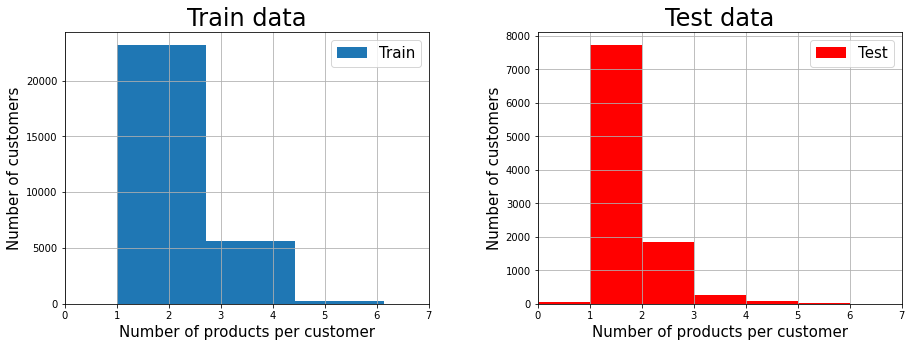

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

train.hist(column='number_of_products', label='Train', ax=axes[0], bins=7)
test.hist(column='number_of_products', label='Test', ax=axes[1], color='r', bins=7)

axes[0].set_xlim([0,7])
axes[1].set_xlim([0,7])

axes[0].set_xlabel('Number of products per customer', fontsize=15)
axes[1].set_xlabel('Number of products per customer', fontsize=15)

axes[0].set_ylabel('Number of customers', fontsize=15)
axes[1].set_ylabel('Number of customers', fontsize=15)

axes[0].set_title("Train data", fontsize=24)
axes[1].set_title("Test data", fontsize=24)

axes[0].legend(fontsize=15)
axes[1].legend(fontsize=15)

### Show the pie chart

In [9]:
products_train = train.iloc[:, -21:-1].sum(axis=0)
products_test = test.iloc[:, -21:-1].sum(axis=0)

Text(0, 0.5, '')

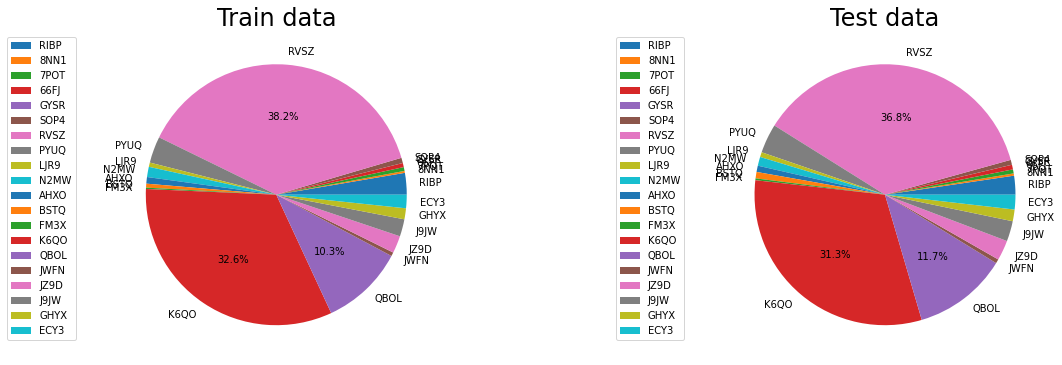

In [10]:
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

fig, axes = plt.subplots(1, 2, figsize=(20,6))

products_train.plot.pie(ax=axes[0], autopct=my_autopct)
products_test.plot.pie(ax=axes[1], autopct=my_autopct)

axes[0].set_title("Train data", fontsize=24)
axes[1].set_title("Test data", fontsize=24)

axes[0].legend(bbox_to_anchor=(-0.1,1.0))
axes[1].legend(bbox_to_anchor=(-0.1,1.0))

axes[0].set_ylabel('')
axes[1].set_ylabel('')

3 products: RVSZ, K6QO and QBOL contribute about 80% to the total chart

In [11]:
(products_train['RVSZ']+products_train['K6QO']+products_train['QBOL'])/products_train.sum()

0.8111531675538733

In [12]:
(products_test['RVSZ']+products_test['K6QO']+products_test['QBOL'])/products_test.sum()

0.797945205479452

## 3. Data preprocessing

### Competition objectives

For each customer ID, for each product, you must predict the <u>**likelihood**</u> that that product is one in use by the customer. <u>**Notice that the sample submission contains 1s for the products that are included in the test set, so that you can focus on the unknown products.**</u>

Leave your predictions as probabilities with values between 0 and 1 and do not round them to 0s or 1s.


### Submisstion format

Lets see how the submission file looks like.

In [13]:
submission = pd.read_csv(FOLDER+'/SampleSubmission.csv')
submission.head()

,ID X PCODE,Label
0,F86J5PC X P5DA,0
1,F86J5PC X RIBP,0
2,F86J5PC X 8NN1,0
3,F86J5PC X 7POT,0
4,F86J5PC X 66FJ,0


### Train data

In the original data, mutliple products might be recommended for a single customer. Below we split our data in such a way that each row corresponds to a <u>single recommendation</u>. Each row includes all customer's data (feature vectors) and a 'target' column with the true recommendation. There might be multiple rows with the same customer's data but with different recommendations. 

Let's give an example. The old format is

|   ID   |  data    |   P5DA | RVSZ   |  K6QO    |
|------|------|------|------|------|
|   CP5S02H  | data | 0 | 1  |  1  |

The new dataframe contains all data (x_train) with target's labels

|   ID   |  data    | target |
|------|------|------|
|CP5S02H | data | RVSZ| 
|CP5S02H | data | K6QO|



In [14]:
def modify_dataframe(df):
  '''
  Function to modify the initial train dataframe into in the format with single recommendation per product per customer. 
  Note, that the new dataframe has the legth corresponding to len(old_dataframe)*total_number_of_recommendations
  '''
  if df.columns[-1] == 'number_of_products':
     df = df.drop(columns=['number_of_products'])

  # Column names. Add product id name of the recommended product.
  columns = list(df.columns[:8])+['target']

  # split part
  new_list = []
  for i, row in enumerate(df.values):
    idxs = list(np.where(row==1))
    for idx in idxs[0]:            
      new_list.append(np.append(row[:8],df.columns[idx]))

  df_new = pd.DataFrame(new_list, columns=columns)

  return(df_new)

# modify the initial dataframe
x_train = modify_dataframe(train)

x_train.head(2)

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,target
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,RVSZ
1,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,K6QO


### Test data

Initial test data has a similar format with the train data. But now we would like to modify it in a slightly different way.   

The first output (x_test) dataframe have exactly the same format as the train dataframe with data. This dataframe will be used for inference to predict the likelihood that product will be in use by the customer. The second dataframe has a form similar to the one of the submission file.

Let's give an example. The old format is

|   ID   |  data    |  RVSZ    |  K6QO    |  P5DA |
|------|------|------|------|------|
|   CP5S02H  | data |  1  |  0  | 1 |
|   F86J5PC  | data |  0  |  1  | 0 |	

We split it into two dataframes. The first one contains all data (x_train)

|   ID   |  data    |
|------|------|
|CP5S02H | data |
|F86J5PC 	 | data | 

and the second one is a target (y_train).

|   ID   | Target |
|------|------|
|CP5S02H X P5DA| 1 |
...
|CP5S02H X RVSZ| 1 |
...
|CP5S02H X K6QO| 0 | 


In [15]:
def get_test_target(df):
  '''
  Function to split the initial test dataframe into the dataframe with data and the dataframe with results. The latter has a format specified in a submission file. 
  '''
  # split part
  target_list = []
  new_list = []
  for i, row in enumerate(df.values):
    new_list.append(row[:8])
    idxs = range(8,29)
    for idx in idxs: 
      target_list.append(np.append(row[0]+' X '+df.columns[idx],row[idx]))

  df_target = pd.DataFrame(target_list, columns=['ID X PCODE', 'target'])
  df_new = pd.DataFrame(new_list, columns=df.columns[:8])

  return(df_new, df_target)

# Pandas index object with the product's names
product_names = list(test.columns[8:-1])

# modify the initial dataframe
x_test, y_test_target = get_test_target(test)

In [16]:
x_test.head(2)

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code
0,F86J5PC,1/12/2018,M,M,1984,94KC,DZRV,90QI
1,H6141K3,1/10/2019,M,M,1996,1X1H,J9SY,90QI


In [17]:
y_test_target.head(2)

,ID X PCODE,target
0,F86J5PC X P5DA,0
1,F86J5PC X RIBP,0


### Clean the data

Get rid of NaN values in the 'join_date' column and fix the inconsistency in the 'marital_status' in the train data (replace small 'f' with the capital one).

In [18]:
# one join date is nan
print('Number of NaN in train:', x_train['join_date'].isna().sum())
print('Number of NaN in test:', x_test['join_date'].isna().sum())
x_train['join_date'].fillna('1/1/2020',inplace=True)  # 1 record
x_test['join_date'].fillna('1/1/2020',inplace=True)   # 7 records

# inconsistency between train and test in marital_status: f must be replaced to F
x_train['marital_status'].replace({'f': 'F'}, inplace=True)

x_train['marital_status'].unique()

Number of NaN in train: 7
Number of NaN in test: 1


array(['M', 'U', 'S', 'W', 'D', 'P', 'R', 'F'], dtype=object)

## 4. Feature engineering

Add some new features such as the age of the customer when he/she has signed the insurance contract with the company.

In [19]:
# split strain 
def add_features(df):
  new = df['join_date'].str.split(pat='/', expand=True)
  nan = type(new[0].unique()[-1])
  #df['join_day'] = new[0].astype(int)
  df['join_month'] = new[1].astype(int)
  df['join_year'] = new[2].astype(int)
  df['join_age'] = df['join_year']-df['birth_year'].astype('int')
  df = df.drop(columns=['join_date'])
  return(df)

x_train = add_features(x_train)
x_test = add_features(x_test)

In [20]:
x_train.head(2)

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,target,join_month,join_year,join_age
0,4WKQSBB,F,M,1987,1X1H,2A7I,T4MS,RVSZ,2,2019,32
1,4WKQSBB,F,M,1987,1X1H,2A7I,T4MS,K6QO,2,2019,32


In [21]:
x_test.head(2)

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,join_month,join_year,join_age
0,F86J5PC,M,M,1984,94KC,DZRV,90QI,12,2018,34
1,H6141K3,M,M,1996,1X1H,J9SY,90QI,10,2019,23


## 5. Machine learning model: fit

Our main machine learning tool will be a recently released [FastAI v2](https://github.com/fastai/fastai) library. 

In [22]:
!pip install fastai2
clear_output()

import fastai2
print(f"fastai version {fastai2.__version__}")

from fastai2.tabular.all import *

fastai version 0.0.30


[Tabular tutorial](https://docs.fast.ai/tutorial.tabular)

In [23]:
splits = RandomSplitter(valid_pct=0.2,seed=42)(range_of(x_train))
splits

((#53083) [46188,7053,51038,2589,62031,7660,52078,1235,5403,55152...],
 (#13270) [41763,16948,46338,6517,9014,31084,6988,41529,10458,16594...])

Our data is in different formats: strings, integers, floats. Before feeding it to the machine learning algorithm (such as the neural network), we must convert it into the numbers i.e. encode the categorical features such as branch code, sex, matiral status etc. You can read more about it in [this article](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c). Here we use a label encoder as implemented in sklearn library. Our data can then beack decoded back to the original format using the inverse transform.

In [24]:
data_tab = TabularPandas(x_train,
                         cat_names = ['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code'],
                         cont_names=['join_age', 'join_month', 'join_year', 'birth_year'],
                         y_names='target',
                         procs=[Categorify, FillMissing,Normalize],
                         splits=splits)
data = data_tab.dataloaders(bs=64)
data.show_batch()

,sex,marital_status,branch_code,occupation_code,occupation_category_code,join_age,join_month,join_year,birth_year,target
0,M,M,94KC,2A7I,T4MS,37.0,10.0,2019.0,1982.0,K6QO
1,M,M,1X1H,SST3,56SI,32.0,4.0,2019.0,1987.0,RVSZ
2,M,M,30H5,2A7I,T4MS,33.0,8.0,2019.0,1986.0,RVSZ
3,M,M,748L,OPVX,T4MS,33.0,7.0,2016.0,1983.0,RVSZ
4,M,M,XX25,2A7I,T4MS,47.0,6.0,2020.0,1973.0,RVSZ
5,F,S,1X1H,UJ5T,T4MS,50.0,3.0,2020.0,1970.0,K6QO
6,F,M,748L,2A7I,T4MS,52.0,8.0,2018.0,1966.0,RVSZ
7,F,M,748L,BPSA,90QI,49.0,8.0,2018.0,1969.0,J9JW
8,F,M,XX25,OPVX,T4MS,31.0,3.0,2019.0,1988.0,RVSZ
9,F,M,748L,2A7I,T4MS,33.0,4.0,2020.0,1987.0,GHYX


Fit the model

In [25]:
learn = tabular_learner(data, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.563684,1.560249,0.379352,00:13
1,1.493483,1.483259,0.377317,00:13
2,1.462631,1.460695,0.377769,00:12
3,1.439037,1.450538,0.376338,00:13
4,1.447324,1.444186,0.384928,00:13
5,1.419987,1.437411,0.388018,00:13
6,1.414812,1.442777,0.378071,00:13
7,1.404246,1.439579,0.382818,00:13
8,1.395232,1.439391,0.379503,00:13
9,1.424394,1.437088,0.376187,00:12


In [26]:
learn.show_results()

,sex,marital_status,branch_code,occupation_code,occupation_category_code,join_age,join_month,join_year,birth_year,target,target_pred
0,2.0,3.0,8.0,38.0,6.0,2.330391,1.078244,0.662024,-2.177204,17.0,17.0
1,1.0,3.0,3.0,18.0,6.0,0.813987,0.184553,-1.401402,-1.101068,14.0,14.0
2,2.0,3.0,4.0,18.0,6.0,1.030616,0.184553,0.146167,-0.993454,19.0,12.0
3,2.0,3.0,12.0,200.0,6.0,-0.377474,-0.709137,0.662024,0.513137,19.0,12.0
4,1.0,3.0,14.0,3.0,6.0,-0.269159,0.482450,-0.885546,0.082682,12.0,19.0
5,2.0,3.0,5.0,18.0,6.0,0.489043,-1.007034,1.177880,-0.240159,19.0,19.0
6,1.0,7.0,4.0,4.0,6.0,-0.810732,0.780347,-3.464828,0.082682,16.0,18.0
7,2.0,3.0,3.0,18.0,6.0,-1.027361,-0.709137,1.177880,1.266432,14.0,3.0
8,1.0,3.0,2.0,18.0,6.0,0.055785,1.376141,0.662024,0.082682,19.0,19.0


## 6. Machine learning model: inference.

<u>**Predict_probability**</u>: apply the model to the given dataset to predict the probability that the object belongs to the given classes.

In [27]:
# create a DataLoaders object from the test dataframe/
test_dl = data.test_dl(x_test)

# predict the likelihood (inference)
predict = learn.get_preds(dl=test_dl)

# transform the predict object into the dataframe
df_predict = pd.DataFrame(predict[0], columns=product_names)

# add a column with the customer ID 
df_predict['ID'] = x_test['ID']

df_predict.head()

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,ID
0,0.000272,1.454650e-05,6.602742e-07,0.000018,2.633869e-05,0.023652,4.809650e-08,0.026197,1.866606e-08,0.002621,0.000087,0.002929,0.430628,3.780526e-04,0.000107,3.291062e-07,0.001484,0.054035,0.000634,0.456330,0.000588,F86J5PC
1,0.000029,1.471682e-06,5.494080e-12,0.000006,7.273773e-07,0.009989,1.036712e-11,0.009408,4.080658e-12,0.000074,0.000363,0.000073,0.462664,6.434595e-07,0.000021,5.740256e-12,0.000006,0.004512,0.000130,0.512719,0.000003,H6141K3
2,0.000022,5.404498e-06,4.471389e-10,0.002233,6.567420e-05,0.017710,2.943203e-08,0.002708,9.617344e-10,0.007260,0.000179,0.007533,0.299196,2.776487e-04,0.009710,6.452240e-09,0.001967,0.160660,0.000737,0.489700,0.000036,RBAYUXZ
3,0.000027,2.120903e-05,7.586539e-12,0.000289,8.689841e-05,0.009112,5.024915e-06,0.012575,1.848821e-09,0.017770,0.001345,0.013306,0.449780,1.080140e-04,0.000454,1.380941e-07,0.001032,0.027782,0.000082,0.466130,0.000095,KCBILBQ
4,0.000002,7.594521e-07,2.735756e-11,0.000022,6.317606e-03,0.000772,4.178644e-06,0.007759,1.217782e-09,0.363090,0.000643,0.357613,0.072626,1.011598e-04,0.000516,3.054495e-08,0.016597,0.060490,0.000019,0.113423,0.000003,LSEC1ZJ


## 7. Prepare the submit file

In [28]:
def change_format(df):
  '''
  ---
  '''
  target_list = []
  for i, row in enumerate(df.values):
    customer_id = row[-1]
    for j, product_id in enumerate(df.columns[:-1]):
      target_list.append(np.append(customer_id+' X '+product_id,row[j]))

  df_target = pd.DataFrame(target_list, columns=['ID X PCODE', 'target'])

  return(df_target)

y_test_predict = change_format(df_predict)

See [here](https://zindi.africa/competitions/zimnat-insurance-recommendation-challenge/discussions/2483) and [here](https://zindi.africa/competitions/zimnat-insurance-recommendation-challenge/discussions/2004).

"Notice that the sample submission contains 1s for the products that are included in the test set, so that you can focus on the unknown products" , leave 1s as it is because we already know that product is purchased by the customer. For the rest of it, what is the classifier is predicting, leave it as probability between 0 or 1.



In [29]:
# sum predict and target values: 
y_test_predict['sum_target'] = y_test_predict['target'].astype(np.float64).add(y_test_target['target'].astype(np.float64))

a = np.array(y_test_predict['sum_target'].values.tolist())
y_test_predict['Label'] = np.where(a > 1., 1., a).tolist()

# final dataframe in a submission format
df_output = y_test_predict.drop(columns=['sum_target', 'target'])
df_output.head()

,ID X PCODE,Label
0,F86J5PC X P5DA,2.720242e-04
1,F86J5PC X RIBP,1.454650e-05
2,F86J5PC X 8NN1,6.602742e-07
3,F86J5PC X 7POT,1.812740e-05
4,F86J5PC X 66FJ,2.633869e-05


## 8. Download the file to your local machine.

In [30]:
df_output.reset_index(drop=True, inplace=True)
df_output.to_csv('submission_predict_true.csv', index=False)

In [31]:
from google.colab import files

files.download('submission_predict_true.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 0.335820149303918 result